In [1]:
import pandas as pd
import geopandas as gpd

## Census Tracts Shapes

In [2]:
tract_data = gpd.read_file("../CENSO-2010/sp_setores_censitarios.zip")
tract_data.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODS', 'NM_SUBDIST', 'CD_GEOCODD',
       'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP', 'NM_MICRO', 'NM_MESO',
       'CD_GEOCODB', 'NM_BAIRRO', 'ID1', 'geometry'],
      dtype='object')

In [3]:
tract_data.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
tract_data.isna().mean().mean()

0.1633028776697513

<Axes: >

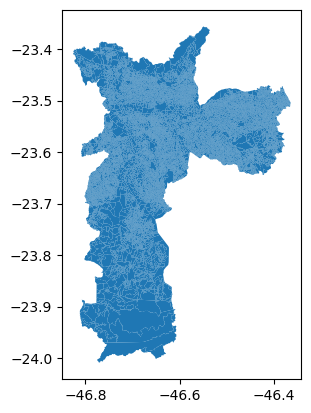

In [5]:
sp_tracts = tract_data[tract_data["NM_MUNICIP"] == "SÃO PAULO"]
sp_tracts.plot()

In [6]:
sp_tracts.NM_DISTRIT.isna().sum()

0

In [7]:
tracts = sp_tracts[["CD_GEOCODI", "geometry"]]
type(tracts)

geopandas.geodataframe.GeoDataFrame

In [8]:
tracts.columns

Index(['CD_GEOCODI', 'geometry'], dtype='object')

In [9]:
tracts.isna().mean().mean()

0.0

## Aggregate crime for each Tract

In [11]:
crime_data = pd.read_csv("../GENERATED-DATA/crime_2017-2018_clean.csv")
crime_data.shape

(811092, 2)

In [12]:
pt_geoms = gpd.points_from_xy(
    x=crime_data["LONGITUDE"],
    y=crime_data["LATITUDE"],
    crs="EPSG:4326",
)

crime_data = gpd.GeoDataFrame(geometry=pt_geoms)

In [13]:
crime_data.head()

,geometry
0,POINT (-46.63540 -23.55476)
1,POINT (-46.63315 -23.54947)
2,POINT (-46.62957 -23.54056)
3,POINT (-46.63434 -23.55056)
4,POINT (-46.63002 -23.54165)


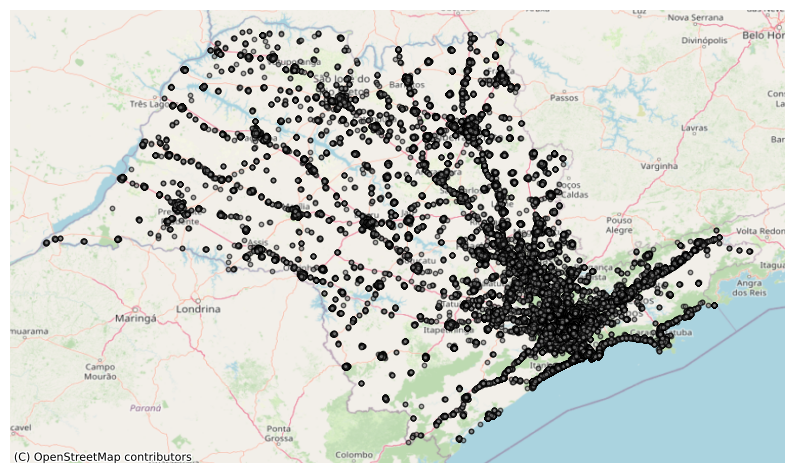

In [14]:
import matplotlib.pyplot as plt
import contextily as cx

fig, ax = plt.subplots(figsize=(10, 10))

crime_data.plot(ax=ax, marker='o', c='gray', edgecolor='k', alpha=0.6, markersize=10)
cx.add_basemap(ax, crs=crime_data.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.axis('off')  # removing axis
plt.show();

In [15]:
tracts = tracts.to_crs("EPSG:4326")

In [16]:
joined_data = tracts.sjoin(
    crime_data,
    how="inner", # crime has to be in a census tract
)

In [17]:
joined_data.head()

,CD_GEOCODI,geometry,index_right
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",729360
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",488858
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",355520
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",554209
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",650471


In [18]:
crimes_agg = joined_data.groupby("CD_GEOCODI").size().rename("CRIMES")
crimes_agg.head()

CD_GEOCODI
355030801000001    50
355030801000002    21
355030801000003    10
355030801000004    19
355030801000005    36
Name: CRIMES, dtype: int64

In [19]:
merged_data = tracts.join(crimes_agg, how="left", on="CD_GEOCODI")

In [20]:
merged_data.isna().sum()

CD_GEOCODI       0
geometry         0
CRIMES        3212
dtype: int64

In [21]:
merged_data.fillna({"CRIMES": 0}, inplace=True)

In [22]:
merged_data.head()

,CD_GEOCODI,geometry,CRIMES
42322,355030804000079,"POLYGON ((-46.51778 -23.57947, -46.51786 -23.5...",24.0
42323,355030804000080,"POLYGON ((-46.51888 -23.57967, -46.51908 -23.5...",7.0
42324,355030804000081,"POLYGON ((-46.52015 -23.58105, -46.52026 -23.5...",10.0
42325,355030804000082,"POLYGON ((-46.52140 -23.57992, -46.52144 -23.5...",7.0
42326,355030804000083,"POLYGON ((-46.52371 -23.58185, -46.52384 -23.5...",7.0


In [24]:
final_data = (
    merged_data
    .astype(
        {"CRIMES": "int64"},
        {"CD_GEOCODI": "object"},    
    )
    .set_index("CD_GEOCODI")
)

final_data = final_data[["CRIMES"]]

final_data.head()

,CRIMES
CD_GEOCODI,
355030804000079,24
355030804000080,7
355030804000081,10
355030804000082,7
355030804000083,7


In [25]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18953 entries, 355030804000079 to 355030896000247
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   CRIMES  18953 non-null  int64
dtypes: int64(1)
memory usage: 296.1+ KB


In [26]:
final_data.nlargest(10, columns="CRIMES")

,CRIMES
CD_GEOCODI,
355030866000002,3673
355030866000003,2926
355030878000005,2407
355030878000007,2314
355030809000012,2283
355030845000095,2037
355030878000006,1743
355030862000042,1689
355030845000093,1570


In [27]:
final_data["CRIMES"].describe()

count    18953.000000
mean        24.819501
std         82.293928
min          0.000000
25%          2.000000
50%          9.000000
75%         23.000000
max       3673.000000
Name: CRIMES, dtype: float64

## Save Data

In [28]:
# save final_data geopandas dataframe to a file
final_data.to_csv("../GENERATED-DATA/crime_agg_by_tract.csv")

## Visualize

In [29]:
final_data['CRIMES'].max()

3673

In [30]:
final_data.columns

Index(['CRIMES'], dtype='object')

In [35]:
from lets_plot import *
LetsPlot.setup_html()

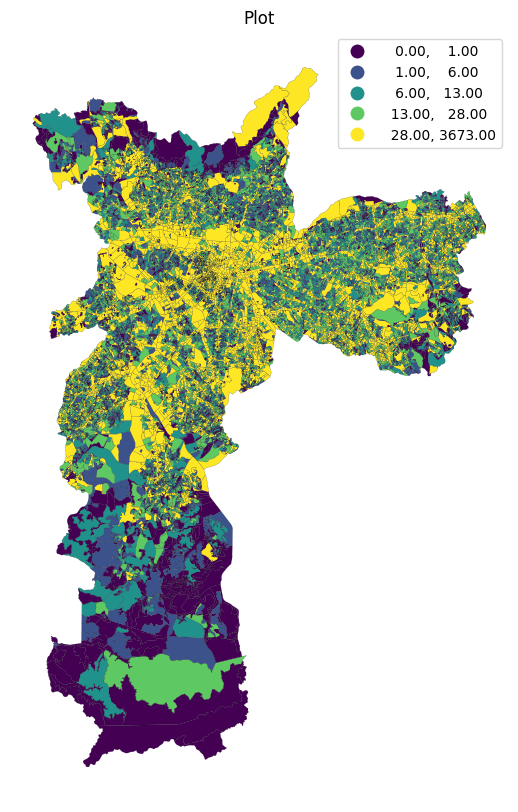

In [33]:
# define a function to:
# plot crime data over the census tracts as a choropleth map
# add a colorbar to the plot
# make the scale of the colorbar logarithmic
def plot_choropleth(data, column, title, legend_title):
    fig, ax = plt.subplots(figsize=(10, 10))
    data.plot(
        ax=ax,
        column=column,
        legend=True,
        scheme="quantiles",
        cmap="viridis",
        edgecolor="k",
        linewidth=0.1,
    )
    ax.set_title(title)
    plt.axis("off")
    plt.show()

plot_choropleth(merged_data, "CRIMES", "Plot", "Crime Count")